In [89]:
#packages importation
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model, load_model
import tensorflow as tf
from keras.preprocessing import image
from sklearn.model_selection import train_test_split

In [21]:
#create a np.array from the images
path = "C:/Users/Emma Molière/Documents/insa/4BIM/Software development/project/2000faces/"

imgs = []
for filemname in os.listdir(path):
    img = image.load_img(path+filemname, target_size = (128,128)) #resize to 128*128
    imgs.append(image.img_to_array(img))
imgs = np.array(imgs)

#imgs.shape

(2000, 128, 128, 3)

In [22]:
#split the data in train and test subsets
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(imgs, test_size=0.2, random_state=0)
print(X_train.shape)

(1600, 128, 128, 3)


In [23]:
#visualize data
def show_faces_data(X, n=10, title=""):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)


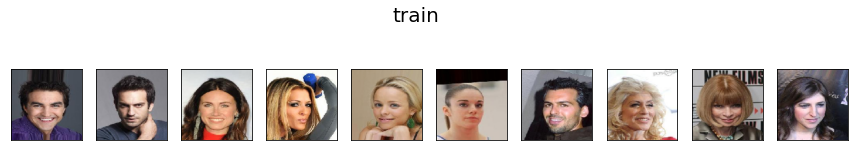

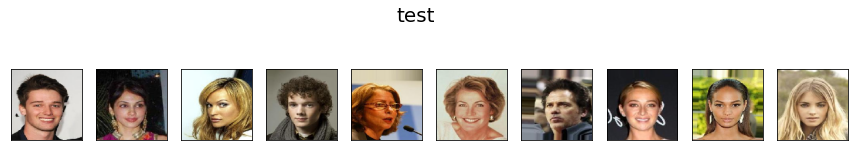

In [24]:
show_faces_data(X_train, title="train")
show_faces_data(X_test, title="test")
plt.show()

Max pooling : used to reduce the spatial dimensions of the output volume.
Conv2D :
first parameter : number of filters (number of kernels to convolve with the input volume. Each of these operations produces a 2D activation map)
then : filter_size : ex (3,3)

In [80]:
input_layer = Input(shape=(128, 128, 3), name="INPUT")
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

In [81]:
code_layer = MaxPooling2D((2, 2), name="CODE")(x)

In [82]:
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(code_layer)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [83]:
faces_AE = Model(input_layer, output_layer)
faces_AE.compile(optimizer='adam', loss='mse')
faces_AE.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 8)         1160      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 8)         584 

In [51]:
faces_AE.fit(X_train, X_train,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/10
50/50 [==============================] - 57s 1s/step - loss: 831.5821 - val_loss: 760.6191
Epoch 2/10
50/50 [==============================] - 53s 1s/step - loss: 740.3017 - val_loss: 712.5529
Epoch 3/10
50/50 [==============================] - 52s 1s/step - loss: 694.8248 - val_loss: 660.8127
Epoch 4/10
50/50 [==============================] - 53s 1s/step - loss: 654.2402 - val_loss: 636.8007
Epoch 5/10
50/50 [==============================] - 52s 1s/step - loss: 629.2274 - val_loss: 611.0361
Epoch 6/10
50/50 [==============================] - 54s 1s/step - loss: 607.3052 - val_loss: 594.6329
Epoch 7/10
50/50 [==============================] - 54s 1s/step - loss: 591.2334 - val_loss: 579.8653
Epoch 8/10
50/50 [==============================] - 49s 984ms/step - loss: 576.9650 - val_loss: 568.8409
Epoch 9/10
50/50 [==============================] - 48s 965ms/step - loss: 569.0874 - val_loss: 557.7545
Epoch 10/10
50/50 [==============================] - 49s 981ms/step - loss: 

In [52]:
#Save auto-encoder 
faces_AE.save("C:/Users/Emma Molière/Documents/insa/4BIM/Software development/project/Projet_SD/faces_AE.h5")

In [57]:
#Make a model to get the encoded representation (i.e. intermediate layer output) of a given face picture
get_encoded_face = Model(inputs=faces_AE.input, outputs=faces_AE.get_layer("CODE").output)

In [72]:
#Get encoded faces
encoded_face = get_encoded_face.predict(X_test)
#we convert into a linear vector to make it easier to manage by the genetic algorithm
encoded_face = encoded_face.reshape((len(X_test), 16*16*8))
np.savetxt("C:/Users/Emma Molière/Documents/insa/4BIM/Software development/project/Projet_SD/encoded_faces.txt", encoded_face)


In [69]:
encoded_face.shape

(400, 2048)

In [55]:
#Reconstructed faces
reconstructed_faces = faces_AE.predict(X_test)

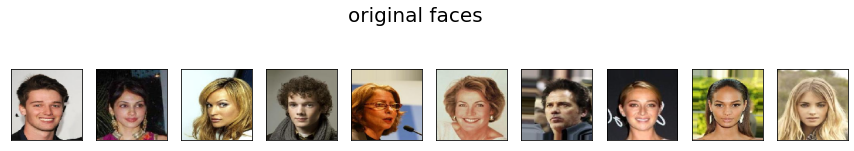

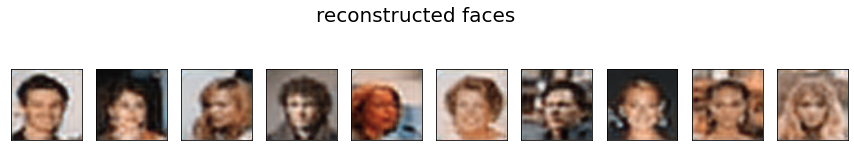

In [56]:
#Visualize the results on test set
show_faces_data(X_test, title="original faces")
#show_faces_data(encoded_face, height=32, width=64, title="encoded faces")
show_faces_data(reconstructed_faces, title="reconstructed faces")

# DECODER 

In [85]:
#Decoder of a given (16*16*8) vector ; NOT LINEAR
input_layer_deco = Input(shape=(16, 16, 8), name="INPUT")
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(input_layer_deco)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
output_layer_deco = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

In [86]:
faces_AE_deco = Model(input_layer_deco, output_layer_deco)
faces_AE_deco.compile(optimizer='adam', loss='mse')
faces_AE_deco.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 16, 16, 8)]       0         
                                                                 
 conv2d_transpose_22 (Conv2D  (None, 16, 16, 8)        584       
 Transpose)                                                      
                                                                 
 up_sampling2d_21 (UpSamplin  (None, 32, 32, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_transpose_23 (Conv2D  (None, 32, 32, 8)        584       
 Transpose)                                                      
                                                                 
 up_sampling2d_22 (UpSamplin  (None, 64, 64, 8)        0         
 g2D)                                                     

In [87]:
#Save decoder 
faces_AE_deco.save("C:/Users/Emma Molière/Documents/insa/4BIM/Software development/project/Projet_SD/faces_decod.h5")

In [91]:
#load the model
decoder = load_model('faces_decod.h5')
#load the encoded vector (numpy.ndarray format)



In [96]:
#loading the txt file with encoded vectors into a np array
encoded_faces_0 = np.loadtxt("C:/Users/Emma Molière/Documents/insa/4BIM/Software development/project/Projet_SD/encoded_faces.txt")


In [98]:
#Reshape the linear vectors into a 16*16*8 dimensuin
encoded_faces = encoded_faces_0.reshape(400, 16, 16, 8)


In [100]:
#Decode on of them using the decoder model we implemented
decoded_faces  = decoder.predict(encoded_faces)

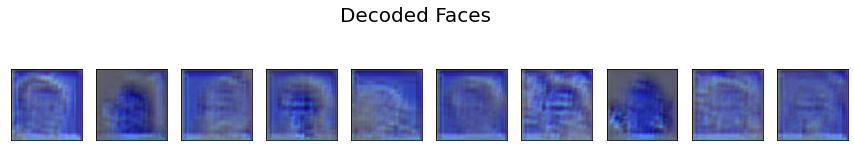

In [101]:
show_faces_data(decoded_faces, title="Decoded Faces")